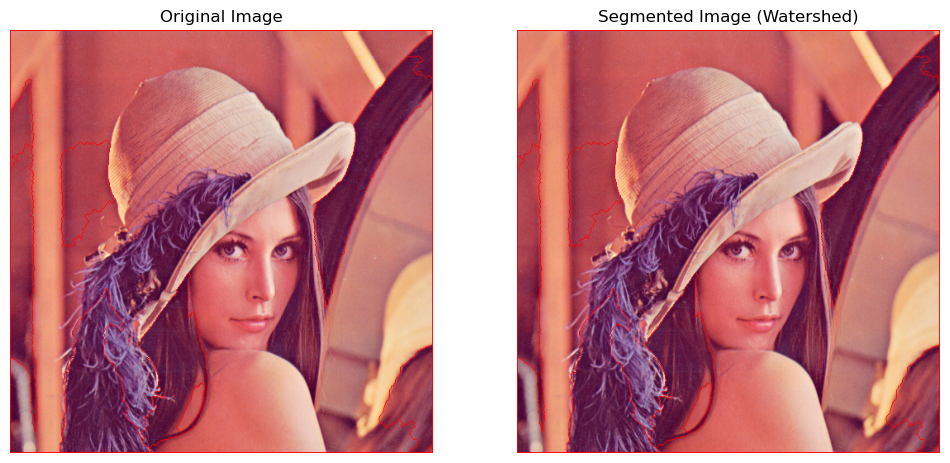

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_watershed(image_path):
    """
    Watershed 변환을 적용하여 이미지 세그먼테이션 수행
    """
    # 이미지 불러오기
    image = cv2.imread(image_path)
    if image is None:
        print(f"이미지를 불러올 수 없습니다. 경로를 확인하세요: {image_path}")
        return None, None

    # 그레이스케일 이미지로 변환
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 이진화 (임계값 처리)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 노이즈 제거 (모폴로지 연산)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # 배경 계산
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # 거리 변환으로 전경 계산
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # 알려지지 않은 영역
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # 마커 생성
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1  # 배경을 1로 설정
    markers[unknown == 255] = 0  # 알려지지 않은 영역을 0으로 설정
    
    # Watershed 적용
    cv2.watershed(image, markers)
    
    # 마커 경계 표시
    image[markers == -1] = [0, 0, 255]  # 경계는 빨간색으로 표시
    
    # 세그먼테이션 결과
    segmented_image = image.copy()
    
    return image, segmented_image

# 시각화
if __name__ == "__main__":
    # 이미지 파일 경로 설정
    image_path = "./image/lena.bmp"  # 실제 이미지 경로로 대체

    # Watershed 적용
    original_image, segmented_image = apply_watershed(image_path)

    if original_image is not None and segmented_image is not None:
        # 원본 이미지와 세그먼테이션 결과 비교
        plt.figure(figsize=(12, 6))

        plt.subplot(121)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        plt.title("Segmented Image (Watershed)")
        plt.axis('off')

        plt.show()
